Dataset Source: https://zenodo.org/record/2586669

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt

from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
ds = pd.read_csv('youtoxic_english.csv', sep=',')

In [53]:
ds.shape

(1000, 15)

In [54]:
ds.head(5)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


For this investigation I will use only 2 columns: Text and isToxic. Let's get rid of the rest of the Data

In [55]:
columns_to_drop = ['CommentId', 'VideoId', 'IsAbusive',	'IsThreat',	'IsProvocative',	'IsObscene',	'IsHatespeech',	'IsRacist',	'IsNationalist',	'IsSexist',	'IsHomophobic',	'IsReligiousHate',	'IsRadicalism']
ds = ds.drop(columns = columns_to_drop, axis=1)

In [56]:
ds.head(5)

,Text,IsToxic
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False


In [57]:
ds['IsToxic'].value_counts()

False    538
True     462
Name: IsToxic, dtype: int64

In [58]:
for comment in ds[ds['IsToxic'] == True]['Text'][:5]:
  print(comment)

Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I thank Wilson for killing that punk bitch.

Dont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing and ironically racist. could they have not come up with somethin better.. or is it just what white folks do to give them selves pride. 'ooo look at me im being nice for the black people' why does it always have to be about race actually the whole world is pussyfootin around for fear of being racist. its fuckin daft man.
here people his facebook is https://www.facebook.com/bassem.masri.520 he has ties with isis and other terrorist groups he is a muslim extremist 
Check out this you tube post. "Black man goes on an epic rant against Ferguson rioters."

Although his message is delivered with childish, cartoon-ish emotions.... He is one of the very few African American's who gets it.
I would LOVE to see this pussy go to Staten Island and spit on a cop. I w

Data preparation for better representation

In [59]:
ds['Text'] = ds['Text'].str.replace('\n', '')

In [60]:
for comment in ds[ds['IsToxic'] == True]['Text'][:5]:
  print(comment, '\n')

Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I thank Wilson for killing that punk bitch. 

Dont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing and ironically racist. could they have not come up with somethin better.. or is it just what white folks do to give them selves pride. 'ooo look at me im being nice for the black people' why does it always have to be about race actually the whole world is pussyfootin around for fear of being racist. its fuckin daft man. 

here people his facebook is https://www.facebook.com/bassem.masri.520 he has ties with isis and other terrorist groups he is a muslim extremist  

Check out this you tube post. "Black man goes on an epic rant against Ferguson rioters."Although his message is delivered with childish, cartoon-ish emotions.... He is one of the very few African American's who gets it. 

I would LOVE to see this pussy go to Staten Island and spit on a cop

Let's use 800 samples as Train

In [61]:
train_ds, test_ds = train_test_split(ds, test_size=200)

In [62]:
test_ds.shape

(200, 2)

The distribution of toxic and normal comments in train and test is not even

In [63]:
test_ds['IsToxic'].value_counts()

False    102
True      98
Name: IsToxic, dtype: int64

In [64]:
train_ds['IsToxic'].value_counts()

False    436
True     364
Name: IsToxic, dtype: int64

In [65]:
sentence_example = ds.iloc[1]['Text']
tokens = word_tokenize(sentence_example, language='english')
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
print(len(tokens_without_punctuation))

25


In [66]:
print(f'Tokens without punctuation: {tokens_without_punctuation}')

Tokens without punctuation: ['Law', 'enforcement', 'is', 'not', 'trained', 'to', 'shoot', 'to', 'apprehend', 'They', 'are', 'trained', 'to', 'shoot', 'to', 'kill', 'And', 'I', 'thank', 'Wilson', 'for', 'killing', 'that', 'punk', 'bitch']


In [67]:
english_stopwords = stopwords.words('english')
tokens_without_punctuation_and_stopwords = [i for i in tokens_without_punctuation if i not in english_stopwords]
print(len(tokens_without_punctuation_and_stopwords))

16


In [68]:
print(f'Tokens without punctuation and stopwords: {tokens_without_punctuation_and_stopwords}')

Tokens without punctuation and stopwords: ['Law', 'enforcement', 'trained', 'shoot', 'apprehend', 'They', 'trained', 'shoot', 'kill', 'And', 'I', 'thank', 'Wilson', 'killing', 'punk', 'bitch']


In [69]:
snowball = SnowballStemmer(language='english')

Delete suffixes with Stemming

In [70]:
stemmed_tokens = [snowball.stem(i) for i in tokens_without_punctuation_and_stopwords]

In [71]:
print(*stemmed_tokens)

law enforc train shoot apprehend they train shoot kill and i thank wilson kill punk bitch


Function to apply tokenization and stemming to samples

In [72]:
snowball = SnowballStemmer(language='english')
english_stopwords = stopwords.words('english')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
  tokens = word_tokenize(sentence, language='english')
  tokens = [i for i in tokens if i not in string.punctuation]
  if remove_stop_words:
    tokens = [i for i in tokens if i not in english_stopwords]
  tokens = [snowball.stem(i) for i in tokens]
  return tokens

Let's test the function

In [73]:
sentence_example = ds.iloc[2]['Text']
print(sentence_example)
print(*tokenize_sentence(sentence_example), sep=', ')

Dont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing and ironically racist. could they have not come up with somethin better.. or is it just what white folks do to give them selves pride. 'ooo look at me im being nice for the black people' why does it always have to be about race actually the whole world is pussyfootin around for fear of being racist. its fuckin daft man.
dont, reckon, black, live, matter, banner, held, white, cunt, kinda, patron, iron, racist, could, come, somethin, better, .., white, folk, give, selv, pride, ooo, look, im, nice, black, peopl, alway, race, actual, whole, world, pussyfootin, around, fear, racist, fuckin, daft, man


We will use LogisticRegression, that's why it's necessary to preprocess the Dataset to transform the text into vectors:

In [74]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))

In [75]:
features = vectorizer.fit_transform(train_ds['Text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [76]:
model = LogisticRegression(random_state=0)
model.fit(features, train_ds['IsToxic'])

LogisticRegression(random_state=0)

Let's see how the model works

In [77]:
model.predict(features[0])

array([ True])

The model predicted that the 1st comment is toxic.

In [78]:
train_ds['Text'].iloc[0]

'Mike Brown was a criminal thug. Fuck him'

The prediction is correct

In [79]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model', LogisticRegression(random_state=0))
])

In [80]:
model_pipeline.fit(train_ds['Text'], train_ds['IsToxic'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7b00e4e432e0>)),
                ('model', LogisticRegression(random_state=0))])

Let's test the model

In [81]:
model_pipeline.predict(['He is a bad person. He should kill himself!!!'])

array([ True])

The prediction was correct

In [82]:
model_pipeline.predict(['He is a good person. I wish him all the best!!!'])

array([False])

The prediction was correct

Gauge the model using Precision and Recall

In [83]:
precision_score(y_true=test_ds['IsToxic'], y_pred = model_pipeline.predict(test_ds['Text']))

0.7391304347826086

In [84]:
recall_score(y_true=test_ds['IsToxic'], y_pred = model_pipeline.predict(test_ds['Text']))

0.5204081632653061

In [85]:
precision, recall, threshold = precision_recall_curve(y_true = test_ds['IsToxic'], probas_pred = model_pipeline.predict_proba(test_ds['Text'])[:,1])

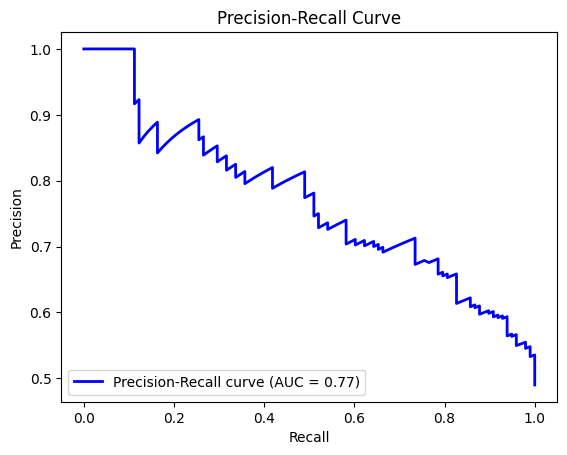

In [86]:
#plot_precision_recall_curve(dt, testX, testy, ax = plt.gca(), name = "Decision Tree")
#plot_precision_recall_curve(estimator=model_pipeline, X=test_ds['Text'], y=test_ds['IsToxic'])

from sklearn.metrics import precision_recall_curve, auc
auc_score = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [87]:
np.where(precision > 0.95)

(array([188, 189, 190, 191, 192, 193, 194, 195, 196, 197]),)

With threshold = 189 or more precision > 0.95

In [88]:
threshold[189]

0.6990159472382362

The minimal threshold = 0.73 for precision > 0.95

In [89]:
precision_score(y_true=test_ds['IsToxic'], y_pred = model_pipeline.predict_proba(test_ds['Text'])[:,1] > threshold[189])

1.0

In [90]:
recall_score(y_true=test_ds['IsToxic'], y_pred = model_pipeline.predict_proba(test_ds['Text'])[:,1] > threshold[189])

0.09183673469387756

The results for precision and recall for threshold = 189

In [91]:
grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', GridSearchCV(
        LogisticRegression(random_state=0),
        # egularization parameter 0.1, 1, 10
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
        verbose=4
    ))
])

In [92]:
grid_pipeline.fit(train_ds['Text'], train_ds['IsToxic'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.558 total time=   0.0s
[CV 2/3] END .............................C=0.1;, score=0.566 total time=   0.0s
[CV 3/3] END .............................C=0.1;, score=0.571 total time=   0.0s
[CV 1/3] END ...............................C=1;, score=0.734 total time=   0.0s
[CV 2/3] END ...............................C=1;, score=0.689 total time=   0.0s
[CV 3/3] END ...............................C=1;, score=0.688 total time=   0.0s
[CV 1/3] END ............................C=10.0;, score=0.723 total time=   0.0s
[CV 2/3] END ............................C=10.0;, score=0.708 total time=   0.0s
[CV 3/3] END ............................C=10.0;, score=0.711 total time=   0.0s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7b00e4e5b010>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

For C=10:

In [93]:
model_pipeline_c_10 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model', LogisticRegression(random_state=0, C=10.))
])

In [94]:
model_pipeline_c_10.fit(train_ds['Text'], train_ds['IsToxic'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7b00e4e33400>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [97]:
precision_c_10, recall_c_10, threshold_c_10 = precision_recall_curve(y_true = test_ds['IsToxic'], probas_pred = model_pipeline_c_10.predict_proba(test_ds['Text'])[:,1])

In [98]:
np.where(precision_c_10 > 0.95)

(array([180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197]),)

In [99]:
precision_score(y_true=test_ds['IsToxic'], y_pred = model_pipeline_c_10.predict_proba(test_ds['Text'])[:,1] > threshold_c_10[189])

1.0

In [100]:
recall_score(y_true=test_ds['IsToxic'], y_pred = model_pipeline_c_10.predict_proba(test_ds['Text'])[:,1] > threshold_c_10[189])

0.09183673469387756